### Comparing Ben-David et al's Upper Bound with the Analytical Expected Risk

In [1]:
import numpy as np
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

import seaborn as sns
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

In [2]:
fontsize = 20
labelsize = 18
lw = 4
markersize = 8

In [3]:
def get_expected_target_risk(n, m, mu, sigma, delta):
    mu_h = (m/(n+m))*(delta/sigma)
    mu = mu/sigma
    sigma_h = np.sqrt(1/(n+m))
    risk = 0.5*(1 + norm.cdf((mu_h - mu)/(np.sqrt(1 + sigma_h**2))) - norm.cdf((mu_h + mu)/(np.sqrt(1 + sigma_h**2))))
    return risk

def compute_divergence(mu, sigma, delta, ns):
    def func(z):
        c, c_dash = z
        def prob(u1, u2):
            p = 0.5 * ( norm.cdf((u1 + mu)/sigma) + norm.cdf((u1 - mu)/sigma) 
                        - norm.cdf((u2 + mu)/sigma) - norm.cdf((u2 - mu)/sigma))
            return p
        A_max = max(c, c_dash)
        A_min = min(c, c_dash)
        return -2 * abs(prob(A_max-delta, A_min-delta) - prob(A_max, A_min)) 
    rranges = (slice(0, delta, ns), slice(0, delta, ns))
    resbrute = optimize.brute(func, rranges, full_output=True,
                          finish=optimize.fmin)
    return -resbrute[1]

def get_upper_bound(n, m, mu, sigma, delta, div, eps=0.7):
    term1 = norm.cdf(-(mu/sigma))

    term2 = 4 * np.sqrt( ( 4 * np.log(2*(n+m+1)) + 2 * np.log(8/eps) ) / (n + m) )

    lamda = norm.cdf((-delta/2 - mu)/sigma) + norm.cdf((delta/2 - mu)/sigma)
    term3 = 2 * m/(n+m) * (0.5 * div + lamda)

    bound = term1 + term2 + term3
    return bound

In [20]:
mu = 1
sigma = 1
n =  50
m_sizes = np.arange(0, 40, 1)
delta_list = [3, 5, 7]
ns = 1

results = []
for i, delta in enumerate(delta_list):
    div = compute_divergence(mu, sigma, delta, ns)
    risk = [get_expected_target_risk(n, m, mu, sigma, delta) for m in m_sizes]
    bound = [get_upper_bound(n, m, mu, sigma, delta, div) for m in m_sizes]
    results.append((risk, bound))

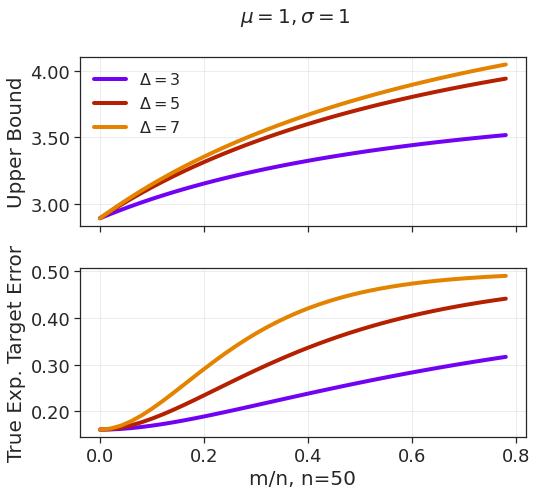

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(8, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]

ax = axes[0]
for i, delta in enumerate(delta_list):
    _ , bound = results[i]
    ax.plot(m_sizes/n, bound, lw=lw, label=r"$\Delta = {}$".format(delta), color=cmap[i])
ax.set_xticklabels("")
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='y', labelsize=labelsize)
ax.set_ylabel("Upper Bound", fontsize=fontsize)
ax.legend(fontsize=labelsize-2, frameon=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax = axes[1]
for i, delta in enumerate(delta_list):
    risk, _ = results[i]
    ax.plot(m_sizes/n, risk, lw=lw, label=r"$\Delta = {}$".format(delta), color=cmap[i])
ax.set_xlabel(r"m/n, n={}".format(n), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.set_ylabel("True Exp. Target Error", fontsize=fontsize)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.suptitle(r"$\mu = {}, \sigma = {}$".format(mu, sigma), fontsize=fontsize)

left = mpl.rcParams["figure.subplot.left"] # the left side of the subplots of the figure
right = mpl.rcParams["figure.subplot.right"]    # the right side of the subplots of the figure
bottom = mpl.rcParams["figure.subplot.bottom"]    # the bottom of the subplots of the figure
top = mpl.rcParams["figure.subplot.top"]     # the top of the subplots of the figure
wspace = mpl.rcParams["figure.subplot.wspace"]    # the amount of width reserved for blank space between subplots
hspace = mpl.rcParams["figure.subplot.hspace"] + 0.05    # the amount of height reserved for white space between subplots
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)


In [22]:
fig.savefig("bound4.pdf", bbox_inches="tight")

### An Attempt at Approximately Recreating Ben-David et al's Fig 3(a)

In [504]:
def get_upper_bound(alpha, n, m, mu, sigma, delta, div, eps=1e-2):
    beta = n/(n+m)

    term1 = norm.cdf(-(mu/sigma))

    term2 = 4 * np.sqrt(alpha**2 / beta + (1-alpha)**2/(1-beta)) * np.sqrt( ( 4 * np.log(2*(n+m+1)) + 2 * np.log(8/eps) ) / (n + m) )

    lamda = norm.cdf((-delta/2 - mu)/sigma) + norm.cdf((delta/2 - mu)/sigma)
    term3 = 2 * (1-alpha) * (0.5 * div + lamda)

    bound = term1 + term2 + term3
    return bound

def get_expected_risk(alpha, n, m, mu, sigma, delta):
    mu_h = ((1-alpha)*m/(alpha*n + (1-alpha)*m))*(delta/sigma)
    sigma_h = np.sqrt((alpha**2*n + (1-alpha)**2*m)/(alpha*n + (1-alpha)*m)**2)
    mu = mu/sigma
    risk = 0.5*(1 + norm.cdf((mu_h - mu)/(np.sqrt(1 + sigma_h**2))) - norm.cdf((mu_h + mu)/(np.sqrt(1 + sigma_h**2))))
    return risk

In [505]:
alpha_list = np.arange(0, 1, 0.1)
delta_list = [0.1, 0.5, 0.8]
ns = 0.1
mu = 1
sigma = 1
n = 10
m = 24
results = []
for i, delta in enumerate(delta_list):
    div = compute_divergence(mu, sigma, delta, ns)
    bound = [get_upper_bound(alpha, n, m, mu, sigma, delta, div) for alpha in alpha_list]
    risk = [get_expected_risk(alpha, n, m, mu, sigma, delta) for alpha in alpha_list]
    results.append((risk, bound))

Text(0.5, 0.98, '$\\mu = 1, \\sigma = 1, n = 10, m = 24$')

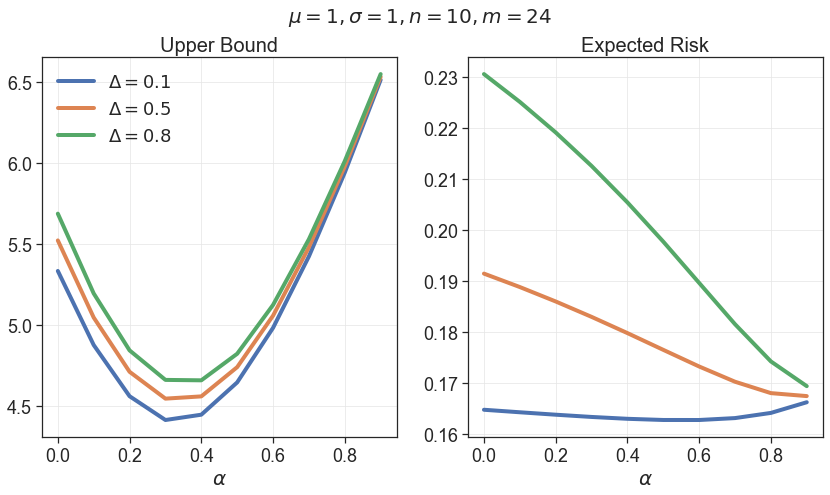

In [506]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

ax = axes[0]
for i, delta in enumerate(delta_list):
    _ , bound = results[i]
    ax.plot(alpha_list, bound, lw=lw, label=r"$\Delta = {}$".format(delta))
ax.set_xlabel(r"$\alpha$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.set_title("Upper Bound", fontsize=fontsize)
ax.legend(fontsize=labelsize, frameon=False)

ax = axes[1]
for i, delta in enumerate(delta_list):
    risk , _ = results[i]
    ax.plot(alpha_list, risk, lw=lw, label=r"$\Delta = {}$".format(delta))
ax.set_xlabel(r"$\alpha$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.set_title("Expected Risk", fontsize=fontsize)
# ax.legend(fontsize=labelsize, frameon=False)

fig.suptitle(r"$\mu = {}, \sigma = {}, n = {}, m = {}$".format(mu, sigma, n, m), fontsize=fontsize)

### Plot $\Delta$ vs $d_{H \Delta H}$

In [522]:
delta_list = np.arange(1, 2, 0.1)
ns = 0.1
mu = 5
sigma = 10
div_list = [compute_divergence(mu, sigma, delta, ns) for delta in delta_list]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


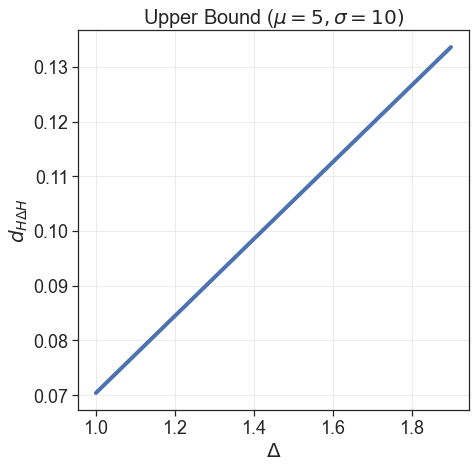

In [525]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(delta_list, div_list, lw=lw)
ax.set_xlabel(r"$\Delta$", fontsize=fontsize)
ax.set_ylabel(r"$d_{H \Delta H}$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.set_title(r"Upper Bound ($\mu = {}, \sigma = {})$".format(mu, sigma), fontsize=fontsize)
ax.legend(fontsize=labelsize, frameon=False)